In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf

/Users/maximeszymanski/PycharmProjects/StocksClusteringVAE/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
!pip install yfinance

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
shape before : (1006,)
shape before : (1006,)
shape before : (1006,)
shape before : (1006,)
shape before : (1006,)
shape after : (1000,)
shape after : (1000,)
shape after : (1000,)
shape after : (1000,)
shape after : (1000,)


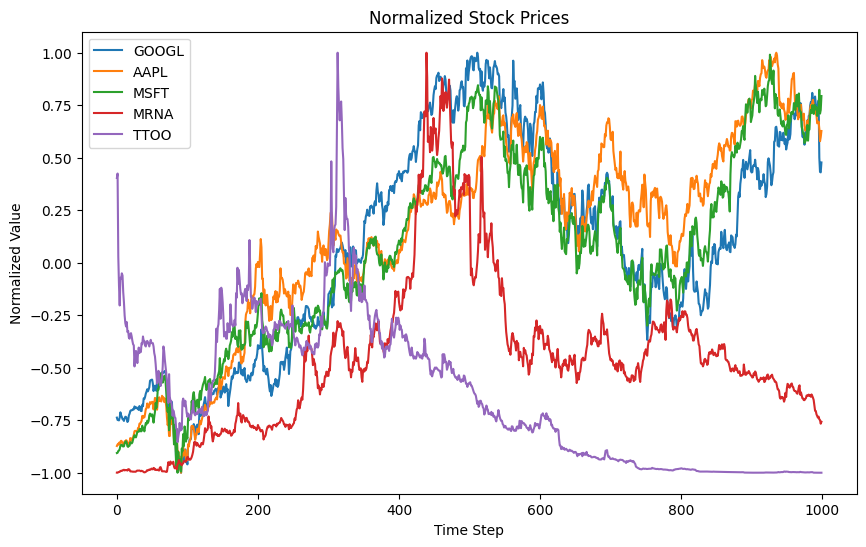

In [3]:

# Define the stock symbol (Google in this case)
stock_symbol_1 = 'GOOGL'
stock_symbol_2 = 'AAPL'
stock_symbol_3 = 'MSFT'
stock_symbol_4 = 'MRNA'
stock_symbol_5 = 'TTOO'
# Define the date range for the past 4 years
start_date = '2019-11-08'
end_date = '2023-11-08'

# Download historical stock data using yfinance
stock_data_1 = yf.download(stock_symbol_1, start=start_date, end=end_date)
stock_data_2 = yf.download(stock_symbol_2, start=start_date, end=end_date)
stock_data_3 = yf.download(stock_symbol_3, start=start_date, end=end_date)
stock_data_4 = yf.download(stock_symbol_4, start=start_date, end=end_date)
stock_data_5 = yf.download(stock_symbol_5, start=start_date, end=end_date)
# Extract the 'Close' column
close_values_1 = stock_data_1['Close'].values
close_values_2 = stock_data_2['Close'].values
close_values_3 = stock_data_3['Close'].values
close_values_4 = stock_data_4['Close'].values
close_values_5 = stock_data_5['Close'].values

# Normalize the data between -1 and 1
normalized_values_1 = 2 * (close_values_1 - np.min(close_values_1)) / np.ptp(close_values_1) -1
normalized_values_2 = 2 * (close_values_2 - np.min(close_values_2)) / np.ptp(close_values_2) -1
normalized_values_3 = 2 * (close_values_3 - np.min(close_values_3)) / np.ptp(close_values_3) -1
normalized_values_4 = 2 * (close_values_4 - np.min(close_values_4)) / np.ptp(close_values_4) -1
normalized_values_5 = 2 * (close_values_5 - np.min(close_values_5)) / np.ptp(close_values_5) -1

print(f"shape before : {normalized_values_1.shape}")
print(f"shape before : {normalized_values_2.shape}")
print(f"shape before : {normalized_values_3.shape}")
print(f"shape before : {normalized_values_4.shape}")
print(f"shape before : {normalized_values_5.shape}")
# remove the last 6 values
normalized_values_1 = normalized_values_1[:-6]
normalized_values_2 = normalized_values_2[:-6]
normalized_values_3 = normalized_values_3[:-6]
normalized_values_4 = normalized_values_4[:-6]
normalized_values_5 = normalized_values_5[:-6]

print(f"shape after : {normalized_values_1.shape}")
print(f"shape after : {normalized_values_2.shape}")
print(f"shape after : {normalized_values_3.shape}")
print(f"shape after : {normalized_values_4.shape}")
print(f"shape after : {normalized_values_5.shape}")
# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.plot(normalized_values_1)
plt.plot(normalized_values_2)
plt.plot(normalized_values_3)
plt.plot(normalized_values_4)
plt.plot(normalized_values_5)
plt.legend([stock_symbol_1,stock_symbol_2,stock_symbol_3,stock_symbol_4,stock_symbol_5])

plt.title('Normalized Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.show()

In [4]:
sub_series_length = 200
assert len(normalized_values_1) % sub_series_length == 0
assert len(normalized_values_2) % sub_series_length == 0
assert len(normalized_values_3) % sub_series_length == 0
assert len(normalized_values_4) % sub_series_length == 0
assert len(normalized_values_5) % sub_series_length == 0

sub_series_1 = normalized_values_1.reshape((-1, sub_series_length))
sub_series_2 = normalized_values_2.reshape((-1, sub_series_length))
sub_series_3 = normalized_values_3.reshape((-1, sub_series_length))
sub_series_4 = normalized_values_4.reshape((-1, sub_series_length))
sub_series_5 = normalized_values_5.reshape((-1, sub_series_length))
print(f"sub_series shape : {sub_series_1.shape}")
print(f"sub_series shape : {sub_series_2.shape}")
print(f"sub_series shape : {sub_series_3.shape}")
print(f"sub_series shape : {sub_series_4.shape}")
print(f"sub_series shape : {sub_series_5.shape}")
number_of_sub_series = sub_series_1.shape[0]

sub_series shape : (5, 200)
sub_series shape : (5, 200)
sub_series shape : (5, 200)
sub_series shape : (5, 200)
sub_series shape : (5, 200)


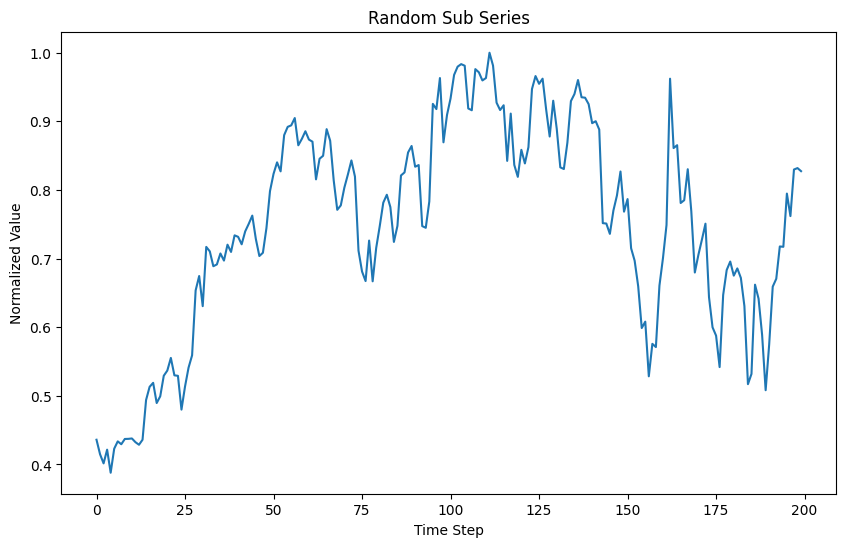

In [5]:
# print a random sub series
random_index = np.random.randint(0, sub_series_1.shape[0])
plt.figure(figsize=(10, 6))
plt.plot(sub_series_1[random_index])
plt.title('Random Sub Series')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.show()


In [6]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
class SamplingLayerVAE(nn.Module):
  def __init__(self):
    super(SamplingLayerVAE, self).__init__()

  def forward(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64,num_layers=3,bidirectional=False,
               transfromer_hidden_size_attention = 128,num_heads=8,sub_seq_len=20,
               latent_dim=64):
    super(Encoder, self).__init__()
    assert seq_len % sub_seq_len  == 0
    self.number_of_sub_seq = seq_len // sub_seq_len
    self.sub_seq_len = sub_seq_len
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    print(f"hidden_dim: {self.hidden_dim}")
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.mu = nn.Linear(self.sub_seq_len*self.embedding_dim, latent_dim)
    self.log_var = nn.Linear(self.sub_seq_len*self.embedding_dim, latent_dim)
    self.sampling_layer = SamplingLayerVAE()
    self.rnn1 = nn.LSTM(
          input_size=embedding_dim,
          hidden_size=self.hidden_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )


    multiple_bi = 2 if bidirectional else 1

    self.rnn2 = nn.LSTM(
          input_size=multiple_bi * self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=self.num_layers,
          batch_first=True
    )
    #self.positional_encoding = PositionalEncoding(embedding_dim)
    self.embedding_layer = nn.Linear(n_features, embedding_dim)
    print(f"embedding_dim: {embedding_dim}")
    self.transformer_1 = CompressWithAttentionResidual(input_size=embedding_dim,output_size=embedding_dim,
                                             hidden_size_attention=embedding_dim,
                                             group_size=self.number_of_sub_seq)


  def forward(self, x):
    batch_size, seq_len, n_features = x.size()
    original_x = x
    #x = x.reshape((batch_size * seq_len, n_features))
    x = self.embedding_layer(x)
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    x = self.transformer_1(x)
    x = x.reshape((batch_size, self.sub_seq_len*self.embedding_dim))
    mu = self.mu(x)
    log_var = self.log_var(x)
    z = self.sampling_layer(mu, log_var)

    return z, mu, log_var, original_x



class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1,num_layers=3,bidirectional=False,
               sub_seq_len=20,latent_dim=64):
    super(Decoder, self).__init__()
    assert seq_len % sub_seq_len  == 0
    self.number_of_sub_seq = seq_len // sub_seq_len
    self.sub_seq_len = sub_seq_len
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.output_embeding = OutputEmbedding(input_dim=self.hidden_dim,seq_len=self.seq_len,output_dim=1)
    self.rnn1 = nn.LSTM(
          input_size=latent_dim,
          hidden_size=input_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )

    multiple_bi = 2 if bidirectional else 1
    self.rnn2 = nn.LSTM(
      input_size=input_dim * multiple_bi,
      hidden_size=self.hidden_dim,
      num_layers=self.num_layers,
      batch_first=True
    )
  def forward(self, x):


    batch_size = x.size(0)
    # x is shape (batch_size, 1, n_features)
    # repeat the last dimension to have (batch_size, seq_len, n_features)
    x = x.unsqueeze(1).repeat(1, self.seq_len, 1)


    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((batch_size,self.seq_len, self.hidden_dim))
    x = self.output_embeding(x)

    # keep only the last layer


    return x

class CompressWithAttentionResidual(nn.Module):
    def __init__(self, input_size, output_size, hidden_size_attention, group_size):
        super(CompressWithAttentionResidual, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size_attention
        self.group_size = group_size

        # Linear projections for attention
        self.Q_linear = nn.Linear(self.input_size, self.hidden_size)
        self.K_linear = nn.Linear(self.input_size, self.hidden_size)
        self.V_linear = nn.Linear(self.input_size, self.hidden_size)

        # Final linear transformations
        self.attention_output_linear = nn.Linear(self.hidden_size, self.hidden_size)
        self.output_linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        # x is shape (batch_size, seq_len, n_features)
        batch_size, seq_len, n_features = x.size()
        # Reshape input into groups of size self.group_size
        x = x.view(batch_size, -1, self.group_size, n_features)
        group_len = x.size(1)

        # Linear projections for attention
        Q = self.Q_linear(x)
        K = self.K_linear(x)
        V = self.V_linear(x)

        # Compute attention weights
        attention_weights = torch.matmul(Q, K.transpose(-2, -1)) / (self.hidden_size ** 0.5)
        attention_weights = F.softmax(attention_weights, dim=-1)

        # Apply attention weights to values
        attended_values = torch.matmul(attention_weights, V)

        # Sum along the group dimension
        attended_values = attended_values.sum(dim=2)

        # Apply final linear transformations
        attention_output = self.attention_output_linear(attended_values)
        # Add residual connection
        out = attention_output

        # Final linear transformation
        out = self.output_linear(out)

        # RElu
        out = F.relu(out)

        return out

class InputEmbedding(nn.Module):
    def __init__(self,seq_len, input_dim=1,output_dim=64):
        super(InputEmbedding, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embedding = nn.Linear(self.input_dim, self.output_dim)
    def forward(self, x):
        batch_size, seq_len, n_features = x.size()
        x = x.reshape((batch_size * seq_len, n_features))
        x = self.embedding(x)
        x = x.reshape((batch_size, seq_len, self.output_dim))
        return x

class OutputEmbedding(nn.Module):
    def __init__(self,seq_len, input_dim=64,output_dim=1):
        super(OutputEmbedding, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embedding = nn.Linear(self.input_dim, self.output_dim)
    def forward(self, x):
        batch_size, seq_len, n_features = x.size()
        x = x.reshape((batch_size * seq_len, n_features))
        x = self.embedding(x)
        x = x.reshape((batch_size, seq_len, self.output_dim))
        return x
"""class PositionalEncoding(nn.Module):
    # write positional encoding for time series data
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        self.max_len = max_len
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.pe = torch.zeros(self.max_len, self.d_model).to(self.device)
        position = torch.arange(0, self.max_len, dtype=torch.float).unsqueeze(1).to(self.device)
        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-math.log(10000.0) / self.d_model)).to(self.device)
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.unsqueeze(0).transpose(0, 1)
    def forward(self, x):
        x = x.permute(1, 0, 2)
        x = x + self.pe[:x.size(0), :]

        return self.dropout(x).permute(1, 0, 2)"""




'class PositionalEncoding(nn.Module):\n    # write positional encoding for time series data\n    def __init__(self, d_model, dropout=0.1, max_len=5000):\n        super(PositionalEncoding, self).__init__()\n        self.dropout = nn.Dropout(p=dropout)\n        self.d_model = d_model\n        self.max_len = max_len\n        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n        self.pe = torch.zeros(self.max_len, self.d_model).to(self.device)\n        position = torch.arange(0, self.max_len, dtype=torch.float).unsqueeze(1).to(self.device)\n        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-math.log(10000.0) / self.d_model)).to(self.device)\n        self.pe[:, 0::2] = torch.sin(position * div_term)\n        self.pe[:, 1::2] = torch.cos(position * div_term)\n        self.pe = self.pe.unsqueeze(0).transpose(0, 1)\n    def forward(self, x):\n        x = x.permute(1, 0, 2)\n        x = x + self.pe[:x.size(0), :]\n\n        return self.dropou

In [7]:
class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=128,sub_seq_len=10,latent_dim=2):
    super(RecurrentAutoencoder, self).__init__()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.encoder = Encoder(seq_len, n_features, embedding_dim,bidirectional=True,num_layers=1,
        sub_seq_len=sub_seq_len,latent_dim=latent_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features,bidirectional=True,num_layers=1,
        sub_seq_len=sub_seq_len,latent_dim=latent_dim).to(device)
  def forward(self, x):
    z, mu, sigma, original_x = self.encoder(x)
    x = self.decoder(z)
    x = nn.Tanh()(x)
    return x, original_x, mu, sigma

In [8]:
print(f"sub_series_length : {sub_series_length}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 2
model = RecurrentAutoencoder(sub_series_length, 1, 256,sub_seq_len=50,latent_dim=latent_dim).to(device)
print(f"model : {model}")

sub_series_length : 200
hidden_dim: 512
embedding_dim: 256
model : RecurrentAutoencoder(
  (encoder): Encoder(
    (mu): Linear(in_features=12800, out_features=2, bias=True)
    (log_var): Linear(in_features=12800, out_features=2, bias=True)
    (sampling_layer): SamplingLayerVAE()
    (rnn1): LSTM(256, 512, batch_first=True, bidirectional=True)
    (rnn2): LSTM(1024, 256, batch_first=True)
    (embedding_layer): Linear(in_features=1, out_features=256, bias=True)
    (transformer_1): CompressWithAttentionResidual(
      (Q_linear): Linear(in_features=256, out_features=256, bias=True)
      (K_linear): Linear(in_features=256, out_features=256, bias=True)
      (V_linear): Linear(in_features=256, out_features=256, bias=True)
      (attention_output_linear): Linear(in_features=256, out_features=256, bias=True)
      (output_linear): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (decoder): Decoder(
    (output_embeding): OutputEmbedding(
      (embedding): Linear(in_feat

In [9]:
def KL_loss(mu, sigma):
    return -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

def reconstruction_loss(x, y):

    return nn.MSELoss(reduction='sum')(x,y)

def loss_function(x, original_x, mu, sigma,k1=1,k2=1e-2):
    return k1 *reconstruction_loss(original_x, x) + k2 * KL_loss(mu, sigma)


In [10]:

# take only square and sinusoidal signals


signal_to_tensor_1 = torch.from_numpy(sub_series_1).float().unsqueeze(2).to(device)
signal_to_tensor_2 = torch.from_numpy(sub_series_2).float().unsqueeze(2).to(device)
signal_to_tensor_3 = torch.from_numpy(sub_series_3).float().unsqueeze(2).to(device)
signal_to_tensor_4 = torch.from_numpy(sub_series_4).float().unsqueeze(2).to(device)
signal_to_tensor_5 = torch.from_numpy(sub_series_5).float().unsqueeze(2).to(device)
print(f'signal to tensor :{signal_to_tensor_2.shape}')
signal_to_tensor_cat = torch.cat((signal_to_tensor_1,signal_to_tensor_2,signal_to_tensor_3,
                                  signal_to_tensor_4,signal_to_tensor_5),dim=0)
print(f"Initial signal shape: {signal_to_tensor_cat.shape}")
x, original_x, mu, sigma = model(signal_to_tensor_cat)
print(f"Input shape: {signal_to_tensor_cat.shape}")
print(f"Output shape: {x.shape}")

signal to tensor :torch.Size([5, 200, 1])
Initial signal shape: torch.Size([25, 200, 1])
Input shape: torch.Size([25, 200, 1])
Output shape: torch.Size([25, 200, 1])


(200,)


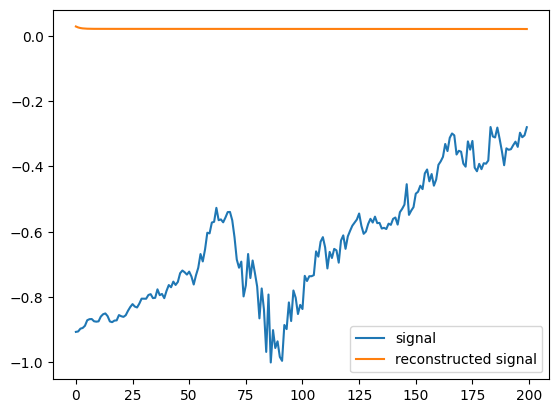

In [11]:
# plot the reconstruction
# get a random signal
random_index = np.random.randint(0, signal_to_tensor_cat.shape[0])
output_decoded = x[random_index].squeeze().cpu().detach().numpy()
# take the first signal
signal = signal_to_tensor_cat[random_index].squeeze().cpu().detach().numpy()
print(signal.shape)
plt.plot(signal, label='signal')
plt.plot(output_decoded, label='reconstructed signal')
plt.legend()
plt.show()


In [12]:
# try a simple overfitting
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#loss_fn = nn.L1Loss(reduction='sum')

for epoch in range(400):
    optimizer.zero_grad()
    x, original_x, mu, sigma = model(signal_to_tensor_cat)

    loss = loss_function(x, original_x, mu, sigma)
    loss.backward()
    # visualize the gradients of the last lstm layer

    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 1677.9566650390625
Epoch: 10, loss: 1109.646484375
Epoch: 20, loss: 525.5216674804688


KeyboardInterrupt: 

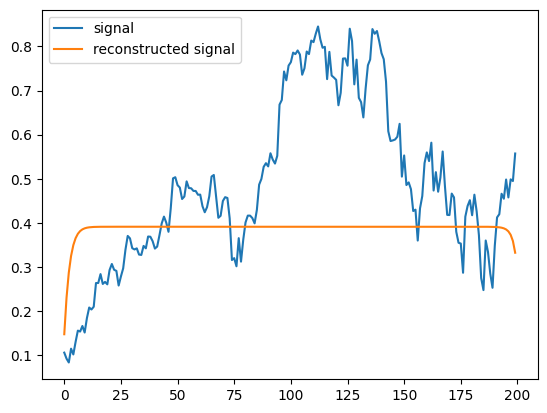

In [13]:
# plot the reconstruction
# get a random signal
random_index = np.random.randint(0, signal_to_tensor_cat.shape[0])
output_decoded = x[random_index].squeeze().cpu().detach().numpy()
# take the first signal
signal = signal_to_tensor_cat[random_index].squeeze().cpu().detach().numpy()
plt.plot(signal, label='signal')
plt.plot(output_decoded, label='reconstructed signal')
plt.legend()
plt.show()


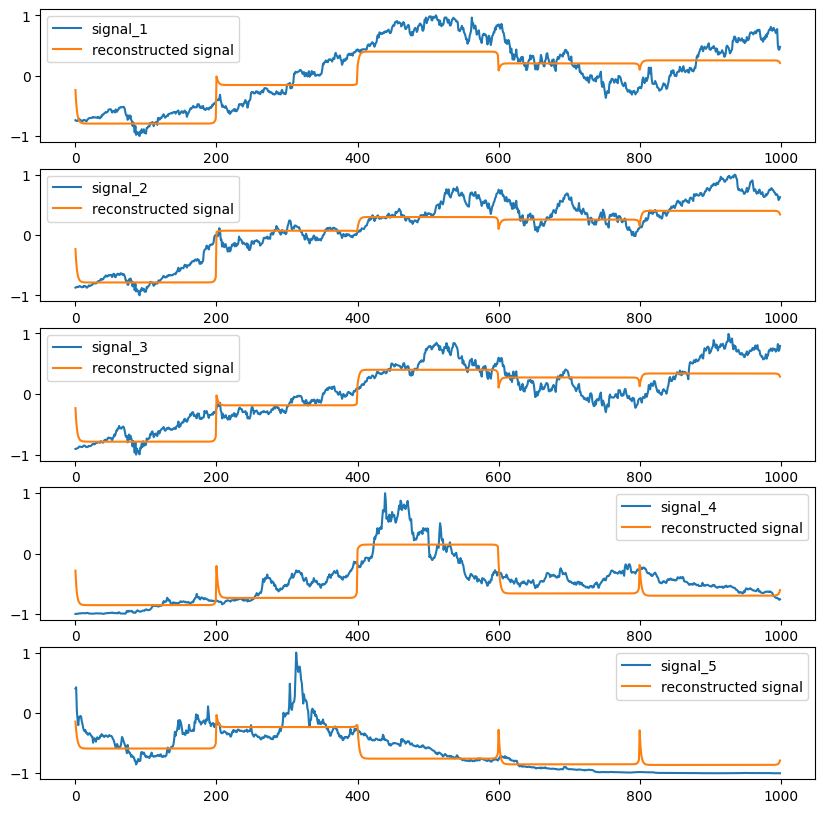

In [14]:
# encode and decode all the signals
signals_1,_,_,_ = model(signal_to_tensor_1)
signals_1 = signals_1.squeeze().cpu().detach().numpy()
signals_2,_,_,_ = model(signal_to_tensor_2)
signals_2 = signals_2.squeeze().cpu().detach().numpy()
signals_3,_,_,_ = model(signal_to_tensor_3)
signals_3 = signals_3.squeeze().cpu().detach().numpy()
signals_4,_,_,_ = model(signal_to_tensor_4)
signals_4 = signals_4.squeeze().cpu().detach().numpy()
signals_5,_,_,_ = model(signal_to_tensor_5)
signals_5 = signals_5.squeeze().cpu().detach().numpy()
# concatenate all the signals

signals_1 = signals_1.reshape(len(normalized_values_1))
signals_2 = signals_2.reshape(len(normalized_values_2))
signals_3 = signals_3.reshape(len(normalized_values_3))
signals_4 = signals_4.reshape(len(normalized_values_4))
signals_5 = signals_5.reshape(len(normalized_values_5))
# Assuming normalized_values_1, normalized_values_2, normalized_values_3,
# signals_1, signals_2, and signals_3 are defined

fig, axes = plt.subplots(5, 1, figsize=(10, 10))

# Plot signal_1 in the first subplot
axes[0].plot(normalized_values_1, label='signal_1')
axes[0].plot(signals_1, label='reconstructed signal')
axes[0].legend()

# Plot signal_2 in the second subplot
axes[1].plot(normalized_values_2, label='signal_2')
axes[1].plot(signals_2, label='reconstructed signal')
axes[1].legend()

# Plot signal_3 in the third subplot
axes[2].plot(normalized_values_3, label='signal_3')
axes[2].plot(signals_3, label='reconstructed signal')
axes[2].legend()

# Plot signal_4 in the fourth subplot
axes[3].plot(normalized_values_4, label='signal_4')
axes[3].plot(signals_4, label='reconstructed signal')
axes[3].legend()

# Plot signal_5 in the fifth subplot
axes[4].plot(normalized_values_5, label='signal_5')
axes[4].plot(signals_5, label='reconstructed signal')
axes[4].legend()
# Show the subplots
plt.show()

signal latent shape : (25, 2)
latent space shape : (25, 2)
normalized_values_1 shape : (1000,)
sequences : 5


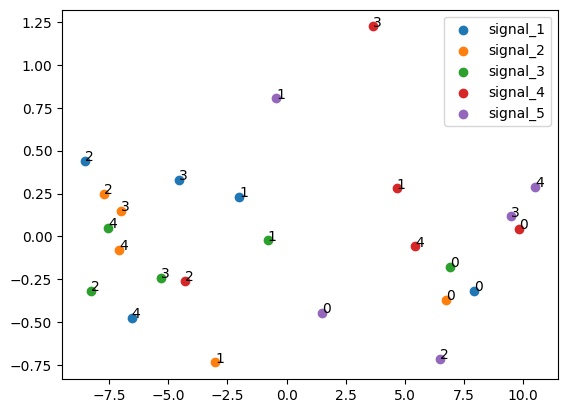

In [15]:
# apply PCA on the latent space
from sklearn.decomposition import PCA
with torch.no_grad():
    # encode and decode all the signals
  signals_latent,_,_,_ = model.encoder(signal_to_tensor_cat)
  signals_latent = signals_latent.squeeze().cpu().detach().numpy()

pca = PCA(n_components=2)
print(f"signal latent shape : {signals_latent.shape}")
latent_space = pca.fit_transform(signals_latent)
print(f"latent space shape : {latent_space.shape}")
print(f"normalized_values_1 shape : {normalized_values_1.shape}")
# decompose the latent space
print(f"sequences : {number_of_sub_series}")
latent_space_1_PCA = latent_space[0:number_of_sub_series]
latent_space_2_PCA = latent_space[number_of_sub_series:2*number_of_sub_series]
latent_space_3_PCA = latent_space[2*number_of_sub_series:3*number_of_sub_series]
latent_space_4_PCA = latent_space[3*number_of_sub_series:4*number_of_sub_series]
latent_space_5_PCA = latent_space[4*number_of_sub_series:5*number_of_sub_series]

latent_space_1 = signals_latent[0:number_of_sub_series]
latent_space_2 = signals_latent[number_of_sub_series:2*number_of_sub_series]
latent_space_3 = signals_latent[2*number_of_sub_series:3*number_of_sub_series]
latent_space_4 = signals_latent[3*number_of_sub_series:4*number_of_sub_series]
latent_space_5 = signals_latent[4*number_of_sub_series:5*number_of_sub_series]

plt.scatter(latent_space_1_PCA[:, 0], latent_space_1_PCA[:, 1], label='signal_1')
plt.scatter(latent_space_2_PCA[:, 0], latent_space_2_PCA[:, 1], label='signal_2')
plt.scatter(latent_space_3_PCA[:, 0], latent_space_3_PCA[:, 1], label='signal_3')
plt.scatter(latent_space_4_PCA[:, 0], latent_space_4_PCA[:, 1], label='signal_4')
plt.scatter(latent_space_5_PCA[:, 0], latent_space_5_PCA[:, 1], label='signal_5')

# Annotate each point with its index
for i in range(number_of_sub_series):
    plt.annotate(str(i), (latent_space_1_PCA[i, 0], latent_space_1_PCA[i, 1]))
    plt.annotate(str(i), (latent_space_2_PCA[i, 0], latent_space_2_PCA[i, 1]))
    plt.annotate(str(i), (latent_space_3_PCA[i, 0], latent_space_3_PCA[i, 1]))
    plt.annotate(str(i), (latent_space_4_PCA[i, 0], latent_space_4_PCA[i, 1]))
    plt.annotate(str(i), (latent_space_5_PCA[i, 0], latent_space_5_PCA[i, 1]))

plt.legend()
plt.show()


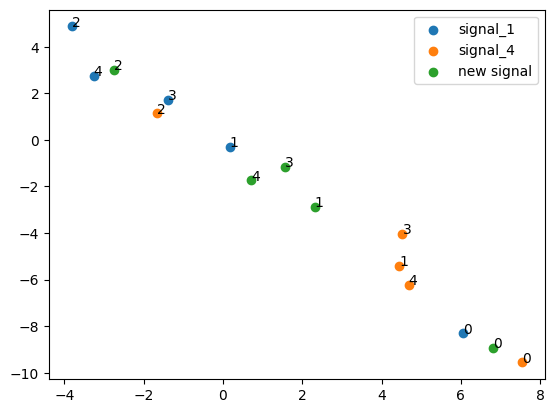

In [21]:
# interpolate between the signal 1 and signal 4, point by point
# take the first signal
signal_1 = latent_space_1
signal_4 = latent_space_4
# define the number of points to interpolate
number_of_points = signal_1.shape[0]

new_signal = np.zeros((number_of_points,latent_dim))
for i in range(number_of_points):
  new_signal[i] = (signal_1[i] + (signal_4[i]) ) / 2

# apply PCA to the new signal
#pca = PCA(n_components=2)
#
# plot the latent space with the 3 signals in different colors
#latent_space_new_signal = pca.fit_transform(new_signal)
latent_space_new_signal = new_signal
plt.scatter(signal_1[:,0],signal_1[:,1],label='signal_1')
plt.scatter(signal_4[:,0],signal_4[:,1],label='signal_4')
plt.scatter(latent_space_new_signal[:,0],latent_space_new_signal[:,1],label='new signal')
for i in range(number_of_points):
    plt.annotate(str(i), (signal_1[i, 0], signal_1[i, 1]))
    plt.annotate(str(i), (signal_4[i, 0], signal_4[i, 1]))
    plt.annotate(str(i), (latent_space_new_signal[i, 0], latent_space_new_signal[i, 1]))
plt.legend()
plt.show()

In [22]:
# decode the new signal
new_signal = torch.from_numpy(new_signal).float().unsqueeze(2).to(device)
print(f"new signal shape : {new_signal.shape}")
new_signal_decoded = model.decoder(new_signal)
# apply tanh to the output
new_signal_decoded = nn.Tanh()(new_signal_decoded)
new_signal_decoded = new_signal_decoded.squeeze().cpu().detach().numpy()
print(f"new signal decoded shape : {new_signal_decoded.shape}")



new signal shape : torch.Size([5, 2, 1])


RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

In [ ]:
# sum all point of each signal in the latent space and plot the result
latent_space_1_sum = np.sum(latent_space_1,axis=0)
latent_space_2_sum = np.sum(latent_space_2,axis=0)
latent_space_3_sum = np.sum(latent_space_3,axis=0)
latent_space_4_sum = np.sum(latent_space_4,axis=0)
latent_space_5_sum = np.sum(latent_space_5,axis=0)

# Define a small neighborhood around the given point
neighborhood_size = 0.1
neighborhood = np.random.uniform(-neighborhood_size, neighborhood_size, size=(number_of_sub_series, 2))

# Generate points around the given point
latent_points_around_given = latent_space_1_sum + neighborhood
# concatenate all the latent points


plt.scatter(latent_space_1_sum[0],latent_space_1_sum[1],label='signal_1')
plt.scatter(latent_space_2_sum[0],latent_space_2_sum[1],label='signal_2')
plt.scatter(latent_space_3_sum[0],latent_space_3_sum[1],label='signal_3')
plt.scatter(latent_space_4_sum[0],latent_space_4_sum[1],label='signal_4')
plt.scatter(latent_space_5_sum[0],latent_space_5_sum[1],label='signal_5')
plt.scatter(latent_points_around_given[:,0],latent_points_around_given[:,1],label='latent points around signal_1')
plt.legend()
plt.show()

In [ ]:
latent_points_around_given = np.concatenate(latent_points_around_given,axis=0)
print(f"latent_points_around_given shape : {latent_points_around_given.shape}")


In [ ]:
# sum all point of each signal in the latent space and plot the result
latent_space_1_sum = np.sum(latent_space_1,axis=0)
latent_space_2_sum = np.sum(latent_space_2,axis=0)
latent_space_3_sum = np.sum(latent_space_3,axis=0)
latent_space_4_sum = np.sum(latent_space_4,axis=0)
latent_space_5_sum = np.sum(latent_space_5,axis=0)
plt.scatter(latent_space_1_sum[0],latent_space_1_sum[1],label='signal_1')
plt.scatter(latent_space_2_sum[0],latent_space_2_sum[1],label='signal_2')
plt.scatter(latent_space_3_sum[0],latent_space_3_sum[1],label='signal_3')
plt.scatter(latent_space_4_sum[0],latent_space_4_sum[1],label='signal_4')
plt.scatter(latent_space_5_sum[0],latent_space_5_sum[1],label='signal_5')
plt.legend()
plt.show()

In [ ]:
# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.plot(normalized_values_1)
plt.plot(normalized_values_2)
plt.plot(normalized_values_3)
plt.plot(normalized_values_4)
plt.plot(normalized_values_5)
plt.legend([stock_symbol_1,stock_symbol_2,stock_symbol_3,stock_symbol_4,stock_symbol_5])

plt.title('Normalized Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.show()